In [ ]:
## Importations

import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from google.colab import drive
from sklearn.cluster import KMeans
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


In [ ]:
## Connecte un google drive à google colab
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
## Lire le fichier excel
df = pd.read_excel('/content/drive/My Drive/Projetinfo1A/COL14042_nettoyé_exel.xlsx')
display(df) # Afficher les données


,Date,Latitude,Longitude
0,1.632232e+09,43.930740,3.100718
1,1.632233e+09,43.930817,3.100728
2,1.632233e+09,43.930970,3.100023
3,1.632233e+09,43.931328,3.100295
4,1.632234e+09,43.931286,3.100298
...,...,...,...
16928,1.648209e+09,43.643814,5.016580
16929,1.648209e+09,43.643974,5.016708
16930,1.648210e+09,43.643703,5.016511
16931,1.648211e+09,43.644207,5.016913


In [ ]:
## Tracer le parcours du méchoui, et ça marche !!!!!!

def coordonnees(debut,fin):
  ''' Cette fct récupère les coordonnées des positions du mouton et les renvoie sous forme de 2 listes (Longitude/Latitude) avec une conversion en mètres (anciennement en degré) '''
  Xdf=[]
  Ydf=[]
  for i in range(debut,fin):
    Xdf.append(df.Longitude[i]*80000) # 80000 est le rapport entre degré et mètre pour cette longitude (les moutons se déplacent peu à l'échelle du globe : même longitude)
    Ydf.append(df.Latitude[i]*111000) # 111000 est le rapport entre degré et mètre pour cette latitude (les moutons se déplacent peu à l'échelle du globe : même latitude)
  return (Xdf,Ydf)


def mechoui(debut,fin):
  '''Cette fonction permet d'afficher un graphique avec le parcours du mouton entre deux instants debut et fin '''
  plt.close()
  Xdf,Ydf=coordonnees(debut,fin)
  plt.plot(Xdf,Ydf,color='green')
  #plt.plot(Xdf,Ydf,color='green',marker='+',linestyle=':',linewidth=4)  # affiche en vert des croix et des lignes de points
  #plt.xlim(x.min(),x.max())
  #plt.ylim(y.min(),y.max())
  plt.show()

In [ ]:
## Calcul de la vitesse

def vitesse(debut,fin):
  ''' Cette fct calcule la vitesse du mouton sur chaque segment de déplacement. C'est une vitesse moyenne car on utilise un pas de temps de 5 minutes '''
  Xdf,Ydf=coordonnees(debut,fin)
  Liste_vitesse=[]  # va stocker les valeurs de vitesse
  for k in range(0,fin-debut-1): # calcul des vitesses
    Liste_vitesse.append(sqrt((Xdf[k+1]-Xdf[k])**2+(Ydf[k+1]-Ydf[k])**2)/(df.Date[k+1]-df.Date[k])*3.6)  # les dates sont en secondes, d'où le "*3.6" pour avoir des km/h (plus usuels)

  Date=[]  # va stocker les valeurs de temps en jours et partant de zéro, plus simple à visualiser qu'avec des "16 milliards de secondes"
  for k in range(debut,fin-1):
    Date.append((df.Date[k]-df.Date[debut]+150)/60/60/24)  # le "/60/60/24" correspond à la conversion des secondes en jours ; le "+150" donne l'instant entre deux mesures (toutes les 300 secondes)

  return (Liste_vitesse , Date)


def affiche_vitesse(debut,fin):
  ''' Cette fct trace un graphique de la vitesse de la brebis en fonction du temps '''
  Liste_vitesse , Date = vitesse(debut,fin)
  plt.close()
  plt.plot(Date,Liste_vitesse)
  plt.title("vitesse du méchoui")
  plt.xlabel("temps (jour)")
  plt.ylabel("vitesse (km/h)")
  plt.show()

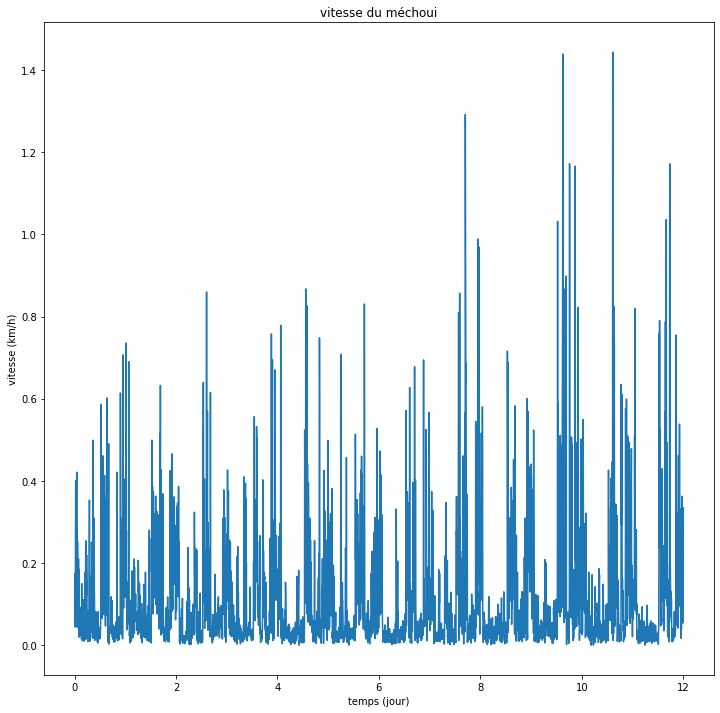

In [ ]:
affiche_vitesse(600,4000)

In [ ]:
## Détermination des moyennes de vitesse de chaque KMeans 1D 

def Kmeans():
  '''Ce programme détermine le centre de 4 clusters de vitesse par la méthode des KMeans '''
  Liste_vitesse = vitesse(0,4000)[0]  # on détermine les vitesses moyennes en prenant une référence de 2 semaines
  tableau_vitesse = np.zeros(len(Liste_vitesse))

  for k in range(len(Liste_vitesse)):
    tableau_vitesse[k]=Liste_vitesse[k]  # transforme la liste "Liste_vitesse" en un tableau numpy "tableau_vitesse", plus simple à manipuler dans la suite
  
  data = tableau_vitesse
  kmeans = KMeans(n_clusters=4).fit(data.reshape(-1,1))
  kmeans.predict(data.reshape(-1,1))

  return(kmeans.cluster_centers_)


In [ ]:
## Récupération des données dans une liste ordonnée

def Moyenne(debut,fin):
  ''' Ordonne et renvoie les moyennes des clusters par ordre croissant '''
  kmeans=Kmeans()
  moyenne=[]
  for i in range(4):
    c=100
    a=-1
    for k in range(4):
      if kmeans[k,0] < c:
        c=kmeans[k,0]
        a=k
    kmeans[a,0]=200
    moyenne.append(c)
  
  return(moyenne)

In [ ]:
## Tracé des vitesse avec clustering

def clustering(debut,fin):
  ''' tracé des vitesses en couleur selon les clusters '''
  moyenne=Moyenne(debut,fin)
  Liste_vitesse,Date_bis=vitesse(debut,fin)

  premier_cluster=[]   #| vont stocker les indices des 
  deuxieme_cluster=[]  #| vitesses de chaque cluster
  troisieme_cluster=[] #|
  quatrieme_cluster=[] #|

  Liste_1=[]
  Liste_2=[]
  Liste_3=[]
  Liste_4=[]

  Date_1=[]
  Date_2=[]
  Date_3=[]
  Date_4=[]

  limite_premier_cluster = (moyenne[0] + moyenne[1])/2
  limite_deuxieme_cluster = (moyenne[1] + moyenne[2])/2
  limite_troisieme_cluster = (moyenne[2] +moyenne[3])/2


  for k in range(len(Liste_vitesse)):

    if Liste_vitesse[k] < limite_premier_cluster:
      premier_cluster.append(k)
      Liste_1.append(Liste_vitesse[k])
      Date_1.append(Date_bis[k])

    elif Liste_vitesse[k] < limite_deuxieme_cluster:
      deuxieme_cluster.append(k)
      Liste_2.append(Liste_vitesse[k])
      Date_2.append(Date_bis[k])

    elif Liste_vitesse[k] < limite_troisieme_cluster:
      troisieme_cluster.append(k)
      Liste_3.append(Liste_vitesse[k])
      Date_3.append(Date_bis[k])

    else:
      quatrieme_cluster.append(k)
      Liste_4.append(Liste_vitesse[k])
      Date_4.append(Date_bis[k])

  plt.close()
  plt.scatter(Date_1, Liste_1, color="blue")
  plt.scatter(Date_2, Liste_2, color="purple")
  plt.scatter(Date_3, Liste_3, color="green")
  plt.scatter(Date_4, Liste_4, color="red")

In [ ]:
## Afficher le déplacement en couleurs

def parcours_couleurs(debut,fin):
  ''' cette fct permet d'afficher le déplacement de la brebis galeuse avec différentes couleurs suivant sa vitesse '''
  moyenne=Moyenne(debut,fin)
  Xdf,Ydf=coordonnees(debut,fin)
  Liste_vitesse=vitesse(debut,fin)[0]
  z=np.zeros(len(Liste_vitesse))

  for k in range(len(Liste_vitesse)):
    z[k]=Liste_vitesse[k]
  
  limite_cluster = [(moyenne[0] + moyenne[1])/2,(moyenne[1] + moyenne[2])/2,(moyenne[2] + moyenne[3])/2] # les vitesses seront attribuées au cluster dont le centre est le plus proche

  x=np.zeros(len(Xdf))       #| "Xdf" et "Ydf" deviennent des  
  for k in range(len(Xdf)):  #| tableaux numpy plus manipulables 
    x[k]=Xdf[k]              #| pour la suite
  y=np.zeros(len(Ydf))       #|
  for k in range(len(Ydf)):  #|
    y[k]=Ydf[k]              #|

  xmin =x.min()            #| Permet de ramener à zéro les valeurs des 
  ymin =y.min()            #| axes pour avoir des valeurs de distance plus
  for k in range(len(x)) : #| compréhensibles que des "millions de mètres"
    x[k]=x[k]-xmin         #|
  for k in range(len(y)) : #|
    y[k]=y[k]-ymin         #|

  bornes = z  # les bornes des clusters dépendent des vitesses
  #print(bornes)
  # Create a set of line segments so that we can color them individually
  # This creates the points as a N x 1 x 2 array so that we can stack points
  # together easily to get the segments. The segments array for line collection
  # needs to be (numlines) x (points per line) x 2 (for x and y)
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)

  plt.rcParams["figure.figsize"] = (12, 12) # définie la taille d'affichage des graphiques
  fig, axs = plt.subplots()

  # Use a boundary norm instead
  cmap = ListedColormap(['b', 'purple', 'g','r'])
  norm = BoundaryNorm([0, limite_cluster[0],limite_cluster[1],limite_cluster[2],30], cmap.N)  # bornes des vitesses pour les couleurs
  lc = LineCollection(segments, cmap=cmap, norm=norm)
  lc.set_array(bornes)
  lc.set_linewidth(1)
  line = axs.add_collection(lc)
  fig.colorbar(line, ax=axs)

  axs.set_xlim(x.min()-20, x.max()+20)
  axs.set_ylim(y.min()-20, y.max()+20)
  plt.axis('equal')
  plt.title("Déplacement du méchoui et échelle de vitesse", fontsize=20)
  plt.xlabel("Longitude (en mètres, ramenée à zéro)",fontsize=15)
  plt.ylabel("Latitude (en mètres, ramenée à zéro)",fontsize=15)
  plt.show()

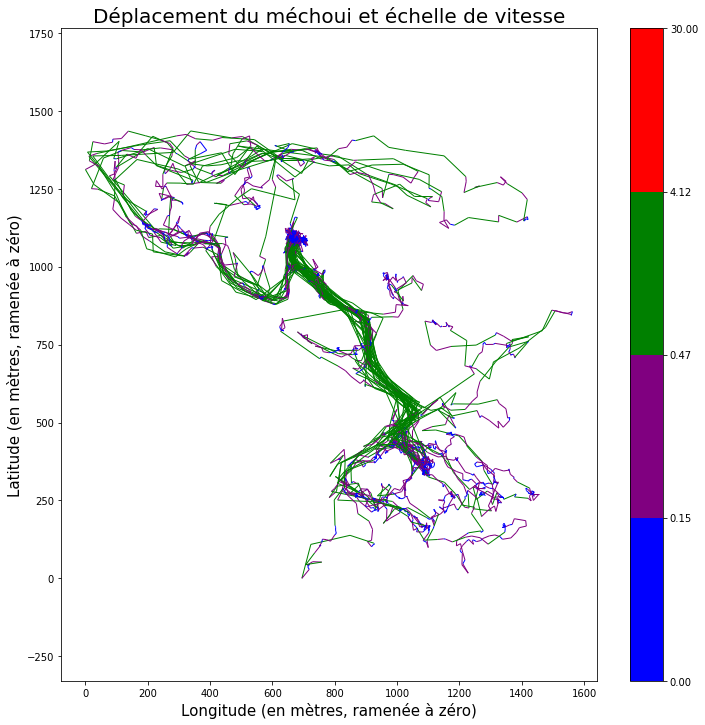

In [ ]:
parcours_couleurs(8200,16000)